# Text Classification on dbpedia data set


<h3>Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer 
import cufflinks as cf
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle
from sklearn.multiclass import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC


<h3>Importing the Train set

In [43]:
data = pd.read_csv('train.csv')
data

,target,title,content
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...
...,...,...,...
559995,14,Barking in Essex,Barking in Essex is a Black comedy play direc...
559996,14,Science & Spirit,Science & Spirit is a discontinued American b...
559997,14,The Blithedale Romance,The Blithedale Romance (1852) is Nathaniel Ha...
559998,14,Razadarit Ayedawbon,Razadarit Ayedawbon (Burmese: ရာဇာဓိရာဇ် အရေး...


<h4>We will now append the column (Class) that defines the name of the target class

In [45]:
def append_col(data):
    data.loc[data['target'] == 1, 'Class'] = 'Company'
    data.loc[data['target'] == 2, 'Class'] = 'EducationalInstitution'
    data.loc[data['target'] == 3, 'Class'] = 'Artist'
    data.loc[data['target'] == 4, 'Class'] = 'Athelete'
    data.loc[data['target'] == 5, 'Class'] = 'OfficeHolder'
    data.loc[data['target'] == 6, 'Class'] = 'MeanOfTransportation'
    data.loc[data['target'] == 7, 'Class'] = 'Building'
    data.loc[data['target'] == 8, 'Class'] = 'NaturalPlace'
    data.loc[data['target'] == 9, 'Class'] = 'Village'
    data.loc[data['target'] == 10, 'Class'] = 'Animal'
    data.loc[data['target'] == 11, 'Class'] = 'Plant'
    data.loc[data['target'] == 12, 'Class'] = 'Album'
    data.loc[data['target'] == 13, 'Class'] = 'Film'
    data.loc[data['target'] == 14, 'Class'] = 'WrittenWork'
    return(data)

In [47]:
append_col(data)

,target,title,content,Class
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...,Company
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...,Company
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...,Company
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...,Company
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...,Company
...,...,...,...,...
559995,14,Barking in Essex,Barking in Essex is a Black comedy play direc...,WrittenWork
559996,14,Science & Spirit,Science & Spirit is a discontinued American b...,WrittenWork
559997,14,The Blithedale Romance,The Blithedale Romance (1852) is Nathaniel Ha...,WrittenWork
559998,14,Razadarit Ayedawbon,Razadarit Ayedawbon (Burmese: ရာဇာဓိရာဇ် အရေး...,WrittenWork


<h4>One of our main concerns when developing a classification model is to see whether all the classes are balanced.Means that the dataset should contain an approximately equal portion of each class.


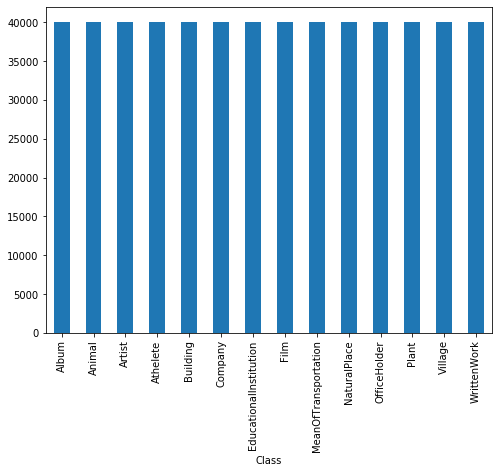

In [5]:
fig = plt.figure(figsize=(8,6))
data.groupby('Class').content.count().plot.bar(ylim=0)
plt.show()

<h3>Importing the Test set

In [44]:
data1 = pd.read_csv('test.csv')
data1

,target,title,content
0,1,TY KU,TY KU /taɪkuː/ is an American alcoholic bever...
1,1,Odd Lot Entertainment,OddLot Entertainment founded in 2001 by longt...
2,1,Henkel,Henkel AG & Company KGaA operates worldwide w...
3,1,GOAT Store,The GOAT Store (Games Of All Type Store) LLC ...
4,1,RagWing Aircraft Designs,RagWing Aircraft Designs (also called the Rag...
...,...,...,...
69995,14,Energy Victory,Energy Victory: Winning the War on Terror by ...
69996,14,Bestiario,Bestiario is a book of 8 short stories writte...
69997,14,Wuthering Heights,Wuthering Heights is a novel by Emily Brontë ...
69998,14,L'Indépendant,L'Indépendant is a newspaper published in Lux...


In [49]:
append_col(data1)

,target,title,content,Class
0,1,TY KU,TY KU /taɪkuː/ is an American alcoholic bever...,Company
1,1,Odd Lot Entertainment,OddLot Entertainment founded in 2001 by longt...,Company
2,1,Henkel,Henkel AG & Company KGaA operates worldwide w...,Company
3,1,GOAT Store,The GOAT Store (Games Of All Type Store) LLC ...,Company
4,1,RagWing Aircraft Designs,RagWing Aircraft Designs (also called the Rag...,Company
...,...,...,...,...
69995,14,Energy Victory,Energy Victory: Winning the War on Terror by ...,WrittenWork
69996,14,Bestiario,Bestiario is a book of 8 short stories writte...,WrittenWork
69997,14,Wuthering Heights,Wuthering Heights is a novel by Emily Brontë ...,WrittenWork
69998,14,L'Indépendant,L'Indépendant is a newspaper published in Lux...,WrittenWork


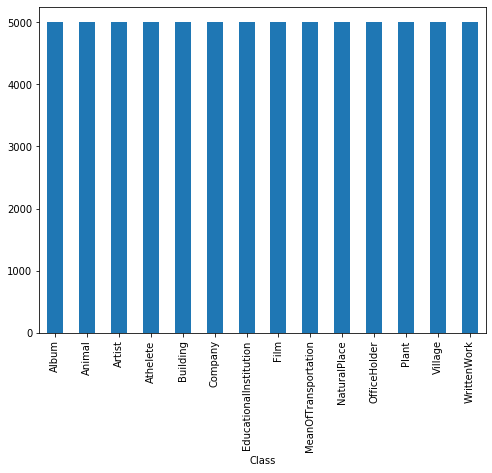

In [8]:
fig = plt.figure(figsize=(8,6))
data1.groupby('Class').content.count().plot.bar(ylim=0)
plt.show()

<h6>From the above bar charts we can see that the data is not skewed(both in train and test).All the target classes have same amount of data.We can say that the data is balanced.

In [9]:
print("Total number of words: ",data['content'].apply(lambda x: len(x.split(' '))).sum())

Total number of words:  26396620


<h4>Counting the frequency of words

In [10]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['content'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['content' , 'count'])

the 1666844
in 938826
of 878833
is 760993
and 722292
was 386398
by 289237
to 278820
it 274500
as 206098
on 184653
for 173675
an 134798
from 128748
at 118805
with 117083
he 115638
school 101753
born 84149
film 78437


<h2>Text Preprocessing

<h4>Punctuations are taken care of.Label coding is already done.
    

<h4>Converting the text to lower case and removing the stop words

In [51]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
data['content'] = data['content'].apply(cleanText)
data1['content'] = data1['content'].apply(cleanText)
data

,target,title,content,Class
0,1,E. D. Abbott Ltd,abbott farnham e abbott limited british coachb...,Company
1,1,Schwan-Stabilo,schwanstabilo german maker pens writing colour...,Company
2,1,Q-workshop,qworkshop polish company located pozna special...,Company
3,1,Marvell Software Solutions Israel,marvell software solutions israel known radlan...,Company
4,1,Bergan Mercy Medical Center,bergan mercy medical center hospital located o...,Company
...,...,...,...,...
559995,14,Barking in Essex,barking essex black comedy play directed harry...,WrittenWork
559996,14,Science & Spirit,science spirit discontinued american bimonthly...,WrittenWork
559997,14,The Blithedale Romance,blithedale romance 1852 nathaniel hawthornes t...,WrittenWork
559998,14,Razadarit Ayedawbon,razadarit ayedawbon burmese burmese chronicle ...,WrittenWork


In [52]:
print("Total number of words after preprocessing:",data['content'].apply(lambda x: len(x.split(' '))).sum())

Total number of words after preprocessing: 16332225


<h4>We can see that the number of words reduced after removing the stopwords

<h5>Counting the frequency of words(Train data)

In [53]:
common_words = get_top_n_words(data['content'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['content' , 'count'])

school 99356
born 80327
film 77040
district 76942
also 74395
album 68104
known 63652
species 61258
first 60045
county 59923
located 58900
family 58230
american 55702
new 53525
village 53272
released 51392
river 50123
united 45849
one 44087
high 40429


<h4>All the stop words are removed from the corpus,also we can see the frequency of words school,born,film is reduced.

<h3>Function to plot ROC curve

In [14]:
def plot_roc(predicted):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes= 14
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(predicted))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2
    plt.figure(figsize=(8,5))
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

<h4>Machines,unlike humans can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert our text into numbers.We use bag of words model to convert our text to numbers

In [15]:
X_train= data['content'] 
y_train= data['target']
X_test= data1['content']
y_test= data1['target']

count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(X_train)

<h4>This BOW model just counts the frequencies of word in a document,it does not take into account the fact that the word might also be having a high frequency of occurrence in other documents as well.

<h4>TF-IDF is a score that represents the relative importance of a term in the document and the entire corpus. TF stands for Term Frequency, and IDF stands for Inverse Document Frequency.To convert values from BOW model to TF-IDF values we execute the following script

In [18]:
tfidf_transformer = TfidfTransformer(use_idf= True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [19]:
X_train_tfidf

<560000x775109 sparse matrix of type '<class 'numpy.float64'>'
	with 13456136 stored elements in Compressed Sparse Row format>

<h4>All this calcuations can be done using a pipeline,which we will be using for other models

<h2>Naive Bayes Classifier

<h4>Naive bayes assumes that the features/words are conditionally independent which means that the occurrence of any feature/word has nothing to do with the occurrence of the other features in the sentence.

In [35]:
NBmodel = MultinomialNB().fit(X_train_tfidf, y_train)
predicted= NBmodel.predict(count_vect.transform(X_test))
acc= np.mean(predicted==data1['target'])
print('\033[1m'+"Accuracy of the model: ",acc*100,'%')

Accuracy of the model:  95.56714285714285 %


<h3>Train and Test Accuracies

In [36]:
print("Train Accuracy: ",accuracy_score(y_train,NBmodel.predict(X_train_tfidf)))
print("Test Accuracy:",accuracy_score(y_test, predicted))

Train Accuracy:  0.9627482142857143
Test Accuracy: 0.9556714285714286


<h5>Train Accuracy just shows how well our model learnt from the training data
<h5>Test Accuracy is a better measure as it is the accuracy of model on unseen data

<h3>Evaluating the model

In [37]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           1       0.94      0.86      0.90      5000
           2       0.95      0.98      0.96      5000
           3       0.94      0.85      0.89      5000
           4       0.98      0.99      0.98      5000
           5       0.96      0.98      0.97      5000
           6       0.97      0.99      0.98      5000
           7       0.94      0.95      0.95      5000
           8       0.98      0.98      0.98      5000
           9       1.00      0.96      0.98      5000
          10       1.00      0.96      0.98      5000
          11       0.98      0.99      0.98      5000
          12       0.91      0.99      0.95      5000
          13       0.95      0.97      0.96      5000
          14       0.90      0.92      0.91      5000

    accuracy                           0.96     70000
   macro avg       0.96      0.96      0.96     70000
weighted avg       0.96      0.96      0.96     70000



<h6>Macro Averaging: P1+P2+........+P14/14,weighted Average is the TF-IDF score

<h3>ROC Plot

/home/msc2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



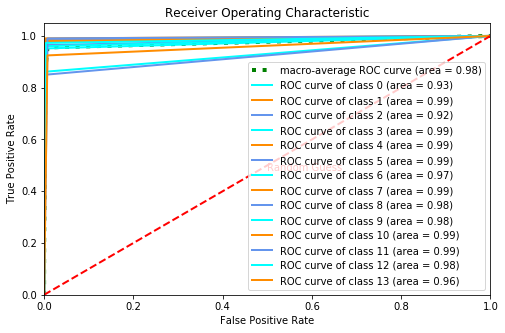

In [38]:
plot_roc(predicted)

<h4>The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

<h4>The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

<h1>Logistic Regression Classifier

In [30]:
classifier = LogisticRegression()

#Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', classifier),])
text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
acc= np.mean(predicted==data1['target'])
print('\033[1m'+"Accuracy of the Logistic Regression classifier is: ",acc*100,'%')

/home/msc2/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy of the Logistic Regression classifier is:  97.85000000000001 %


<h3>Train and Test Accuracies

In [31]:
print("Train Accuracy: ",accuracy_score(y_train,text_clf.predict(X_train)))
print("Test Accuracy:",accuracy_score(y_test, predicted))

Train Accuracy:  0.9859196428571428
Test Accuracy: 0.9785


<h3>Evaluating the model

In [32]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95      5000
           2       0.98      0.98      0.98      5000
           3       0.95      0.94      0.95      5000
           4       0.99      0.99      0.99      5000
           5       0.98      0.98      0.98      5000
           6       0.98      0.99      0.99      5000
           7       0.97      0.97      0.97      5000
           8       0.99      0.99      0.99      5000
           9       1.00      0.99      0.99      5000
          10       0.99      0.99      0.99      5000
          11       0.99      0.99      0.99      5000
          12       0.98      0.99      0.98      5000
          13       0.98      0.98      0.98      5000
          14       0.96      0.97      0.96      5000

    accuracy                           0.98     70000
   macro avg       0.98      0.98      0.98     70000
weighted avg       0.98      0.98      0.98     70000



<h3>ROC Curve

/home/msc2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



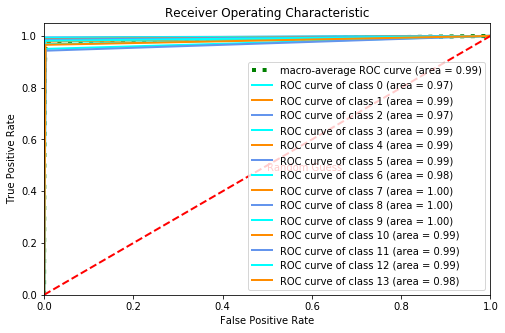

In [34]:
plot_roc(predicted)

<h1>Linear SVC Model

In [39]:
classifier = LinearSVC()

# Create pipeline using Bag of Words
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', classifier),])
text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
acc= np.mean(predicted==data1['target'])
print('\033[1m'+"Accuracy of the Linear SVC classifier is: ",acc*100,'%')

Accuracy of the Linear SVC classifier is:  98.05857142857143 %


<h3>Train and Test Accuracies

In [40]:
print("Train Accuracy: ",accuracy_score(y_train,text_clf.predict(X_train)))
print("Test Accuracy:",accuracy_score(y_test, predicted))

Train Accuracy:  0.9975642857142857
Test Accuracy: 0.9805857142857143


In [41]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           1       0.96      0.95      0.95      5000
           2       0.98      0.98      0.98      5000
           3       0.96      0.94      0.95      5000
           4       0.99      0.99      0.99      5000
           5       0.98      0.98      0.98      5000
           6       0.99      0.99      0.99      5000
           7       0.97      0.97      0.97      5000
           8       0.99      0.99      0.99      5000
           9       1.00      0.99      1.00      5000
          10       0.99      1.00      1.00      5000
          11       1.00      0.99      0.99      5000
          12       0.98      0.99      0.98      5000
          13       0.98      0.98      0.98      5000
          14       0.96      0.97      0.96      5000

    accuracy                           0.98     70000
   macro avg       0.98      0.98      0.98     70000
weighted avg       0.98      0.98      0.98     70000



<h3>ROC Plot

/home/msc2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



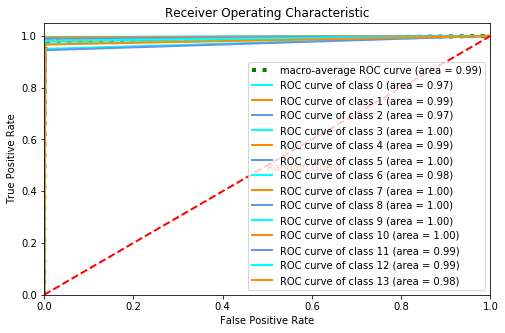

In [42]:
plot_roc(predicted)

<h2>Summary

<h3>Multinomial Naive Bayes :
<h4> Train Accuracy:96.27% 
<h4>Test Accuracy:95.56%
<h3>Logistic Regression :
<h4>Train Accuracy:98.59% 
<h4>Test Accuracy:97.85%
<h3>Linear SVC :   
<h4>Train Accuracy:99.75%
<h4>Test Accuracy:98.05%

<h1>From the above results we can see that Linear SVC is a good classifier with good test accuracy,precision and recall values

<h3>References from Medium,TDS(Towards Data Science),Github,Stack Overflow